In [2]:
import torch
import cv2
import pandas as pd
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# torch.cuda.set_device(0)
# RLE 디코딩 함수
def rle_decode(mask_rle, shape=(224,224)):

    if mask_rle == -1 or mask_rle == '-1':
        return np.zeros(shape)
     
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)


# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

/home/ubin108/anaconda3/envs/jaeung/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [4]:


# 기존 dataloader - testdata 로딩에 사용
class SatelliteDataset1(Dataset):
    def __init__(self, csv_file, transform=None, infer=False):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.infer = infer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 1]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.infer:
            if self.transform:
                image = self.transform(image=image)['image']
            return image

        mask_rle = self.data.iloc[idx, 2]
        mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

transform1 = A.Compose(
    [
        A.Resize(224, 224),
        A.Normalize(),
        ToTensorV2()
    ]
)

# 첫 100행만 읽어오기
df = pd.read_csv('./test.csv', nrows=1024)
# # 파일로 저장하기
df.to_csv('./test_1024.csv', index=False)
# # 이 csv 파일을 새로운 데이터셋으로 사용

test_dataset = SatelliteDataset1(csv_file='./test_1024.csv', transform=transform1, infer=True)
# test_dataset = SatelliteDataset1(csv_file='./test.csv', transform=transform1, infer=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=32)

# # (저장된 모델이 있다면) 모델 가중치 불러오기

from backbones_unet.model.unet import Unet

model = Unet(
    backbone='tf_efficientnetv2_l_in21ft1k',
    in_channels=3,
    num_classes=1,
).to(device=device)

weights = torch.load('/home/ubin108/efficientnet_l/efficientnetV2_l_epoch_119_V2_80803.pth', map_location=device)
model.load_state_dict(weights)

# weights = torch.load('./DeepLabV3Plus/0716_DeepLabV3+_model_epoch_95.pth',map_location=device)
# weights = strip_module_from_state_dict(weights)
# model.load_state_dict(weights)


masksarr = []
with torch.no_grad():
    model.eval()
    result = []
    num_images = 0
    for images in tqdm(test_dataloader):
        images = images.float().to(device)

        outputs = model(images)
        masks = torch.sigmoid(outputs).cpu().numpy()
        masksarr.append(masks)
        masks = np.squeeze(masks, axis=1)
        masks = (masks > 0.6).astype(np.uint8) # Threshold

        for i in range(len(images)):
            mask_rle = rle_encode(masks[i])
            if mask_rle == '': # 예측된 건물 픽셀이 아예 없는 경우 -1
                result.append(-1)
            else:
                result.append(mask_rle)

            num_images += 1

        # if num_images >= 1024: # 이미지 100개만 평가하고 멈춤
        #     break


# submit = pd.read_csv('./sample_submission.csv', nrows=1024)
submit = pd.read_csv('./sample_submission.csv')
submit['mask_rle'] = result
submit.to_csv('./0727_unet_efficientnetV2_l_80803_mask0.6.csv', index=False)


/home/ubin108/anaconda3/envs/jaeung/lib/python3.9/site-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name convnext_large_in22ft1k to current convnext_large.fb_in22k_ft_in1k.
  model = create_fn(
100%|██████████| 1895/1895 [07:57<00:00,  3.97it/s]


In [4]:
# submit = pd.read_csv('./sample_submission.csv', nrows=1024)
submit = pd.read_csv('./sample_submission.csv')
submit['mask_rle'] = result
submit.to_csv('./0722_convnext_xlarge_best_81400.csv', index=False)

In [5]:
import matplotlib.pyplot as plt

# masksarr가 list 형태이므로 numpy array로 변환
masksarr = np.concatenate(masksarr)


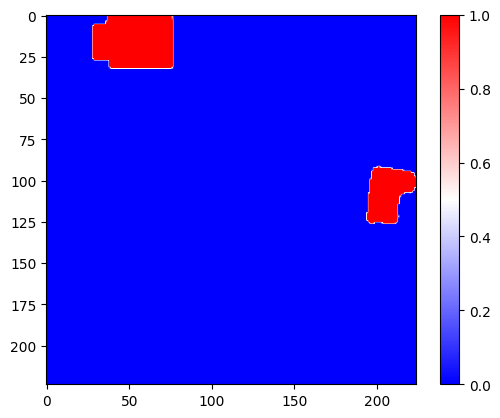

In [56]:
idx = 304
plt.imshow(masksarr[idx][0], cmap='bwr', vmin=0, vmax=1) # vmin과 vmax를 지정
plt.colorbar()  # 확률 값을 나타내는 컬러바를 추가합니다.
plt.show()

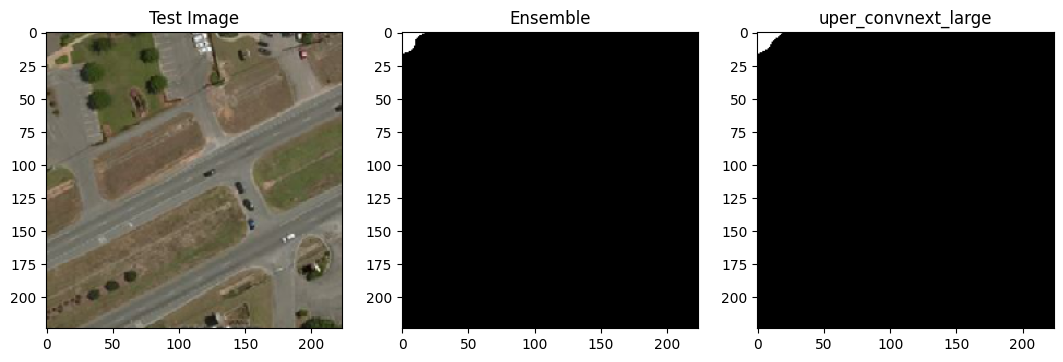

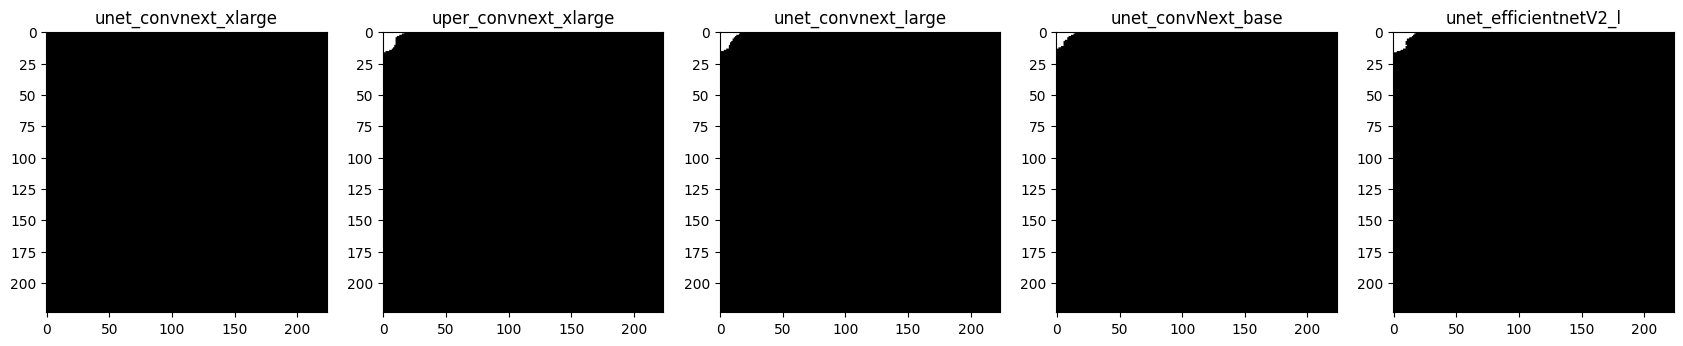

In [22]:
import pandas as pd
import numpy as np
# RLE 디코딩 함수
def rle_decode(mask_rle, shape=(224,224)):

    if mask_rle == -1 or mask_rle == '-1':
        return np.zeros(shape)
     
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)


# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# 데이터 불러오기
# submit1 = pd.read_csv('./convNext_base_epoch_53_best.csv')
submit0 = pd.read_csv('/home/ubin108/0727_ensemble_6_building_4_threshold_0.5_[30, 30, 20, 20, 20, 20].csv')
submit1 = pd.read_csv('/home/ubin108/0725_unet_convnext_xlarge_best_8140_threshold_05.csv')
submit2 = pd.read_csv('/home/ubin108/0727_uper_convnext_xlarge_best_8119_threshold_05.csv')
submit3 = pd.read_csv('/home/ubin108/0727_upernet_convnext_large_0.80845_mask0.5.csv')
submit4 = pd.read_csv('/home/ubin108/0723_efficientnetV2_l_epoch_119_V2_80803.csv')
submit5 = pd.read_csv('/home/ubin108/0723_convnext_large_80.66.csv')
submit6 = pd.read_csv('/home/ubin108/0723_convNext_base_epoch_61_V2_8062.csv')

# 모든 행에 대해 반복
# for idx in range(len(submit1)):
#     # 각 행의 mask_rle을 가져옴
#     mask_rle1 = submit1.loc[idx, 'mask_rle']
#     mask_rle2 = submit2.loc[idx, 'mask_rle']
#     mask_rle3 = submit3.loc[idx, 'mask_rle']
#     mask_rle4 = submit4.loc[idx, 'mask_rle']
#     mask_rle5 = submit5.loc[idx, 'mask_rle']
#     # mask_rle 값이 -1인 경우의 수를 구함
#     minus_one_count = sum(1 for mask_rle in [mask_rle1, mask_rle2, mask_rle3, mask_rle4, mask_rle5] if mask_rle == '-1')

#     # 만약 하나 이상의 파일이 -1로 예측하고, 다른 파일이 -1이 아니라고 예측한 경우
#     if 1 <= minus_one_count <= 1:
#         print(f'{idx}, ')


idx=997

mask_rle0 = submit0.loc[idx, 'mask_rle']
mask_rle1 = submit1.loc[idx, 'mask_rle']
mask_rle2 = submit2.loc[idx, 'mask_rle']
mask_rle3 = submit3.loc[idx, 'mask_rle']
mask_rle4 = submit4.loc[idx, 'mask_rle']
mask_rle5 = submit5.loc[idx, 'mask_rle']
mask_rle6 = submit6.loc[idx, 'mask_rle']

mask0 = rle_decode(mask_rle0, (224, 224))
mask1 = rle_decode(mask_rle1, (224, 224))
mask2 = rle_decode(mask_rle2, (224, 224))
mask3 = rle_decode(mask_rle3, (224, 224))
mask4 = rle_decode(mask_rle4, (224, 224))
mask5 = rle_decode(mask_rle5, (224, 224))
mask6 = rle_decode(mask_rle6, (224, 224))

# 이미지를 화면에 출력
# Display the test image separately
test_image = mpimg.imread(f'./test_img/TEST_{idx:05}.png')
fig, axs = plt.subplots(1, 3, figsize=(13, 4))  # Change to 2 subplots
axs[0].imshow(test_image, cmap='gray')
axs[0].set_title('Test Image')
axs[1].imshow(mask0, cmap='gray')
axs[1].set_title('Ensemble')
axs[2].imshow(mask6, cmap='gray')
axs[2].set_title('uper_convnext_large')

fig, axs = plt.subplots(1, 5, figsize=(21, 4))  # Change to 4 subplots instead of 5
axs[0].imshow(mask1, cmap='gray'), axs[0].set_title('unet_convnext_xlarge')
axs[1].imshow(mask2, cmap='gray'), axs[1].set_title('uper_convnext_xlarge')
axs[2].imshow(mask3, cmap='gray'), axs[2].set_title('unet_convnext_large')
axs[3].imshow(mask4, cmap='gray'), axs[3].set_title('unet_convNext_base')
axs[4].imshow(mask5, cmap='gray'), axs[4].set_title('unet_efficientnetV2_l')

plt.show()